In [2]:
from pydrake.symbolic import Variable
from pydrake.systems.primitives import SymbolicVectorSystem

x = Variable("x")

continuous_vector_system = SymbolicVectorSystem(state=[x], dynamics=[-x + x**3], output=[x])

In [11]:
from pydrake.systems.framework import LeafSystem

class SimpleContinuousTimeSystem(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)

        state_index = self.DeclareContinuousState(1)
        self.DeclareStateOutputPort("y", state_index)

    def DoCalcTimeDerivatives(self, context, derivatives):
        x = context.get_continuous_state_vector().GetAtIndex(0)
        xdot = -x + 1.0 * x**3
        derivatives.get_mutable_vector().SetAtIndex(0, xdot)

continous_system = SimpleContinuousTimeSystem()

Text(0, 0.5, 'y(t)')

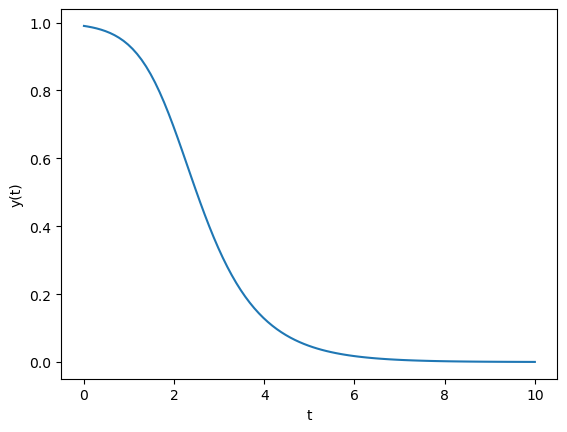

In [17]:
import matplotlib.pyplot as plt 
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

# Create a simple block diagram containing our system
builder = DiagramBuilder()
system = builder.AddSystem(SimpleContinuousTimeSystem())
logger = LogVectorOutput(system.get_output_port(0), builder)
diagram = builder.Build()

context = diagram.CreateDefaultContext()
context.SetContinuousState([0.99])

simulator = Simulator(diagram, context)
simulator.AdvanceTo(10)

log = logger.FindLog(context)
plt.figure()
plt.plot(log.sample_times(), log.data().transpose())
plt.xlabel('t')
plt.ylabel('y(t)')

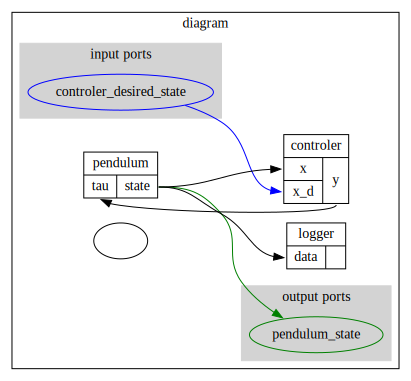

In [20]:
import numpy as np
import pydot
from IPython.display import SVG, display
from pydrake.examples import PendulumPlant
from pydrake.systems.analysis import Simulator
from pydrake.systems.controllers import PidController
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

builder = DiagramBuilder()

# Add pendulum and controller systems
pendulum = builder.AddNamedSystem("pendulum", PendulumPlant())
controller = builder.AddNamedSystem("controler",
                                    PidController(kp=[10.], ki=[1.], kd=[1.]))

# Hook up ports
builder.Connect(pendulum.get_state_output_port(),
                controller.get_input_port_estimated_state())
builder.Connect(controller.get_output_port_control(),
                pendulum.get_input_port())

builder.ExportInput(controller.get_input_port_desired_state())
builder.ExportOutput(pendulum.get_state_output_port())

logger = LogVectorOutput(pendulum.get_state_output_port(), builder)
logger.set_name("logger")

diagram = builder.Build()
diagram.set_name("diagram")

display(SVG(pydot.graph_from_dot_data(
    diagram.GetGraphvizString(max_depth = 2))[0].create_svg()
    ))


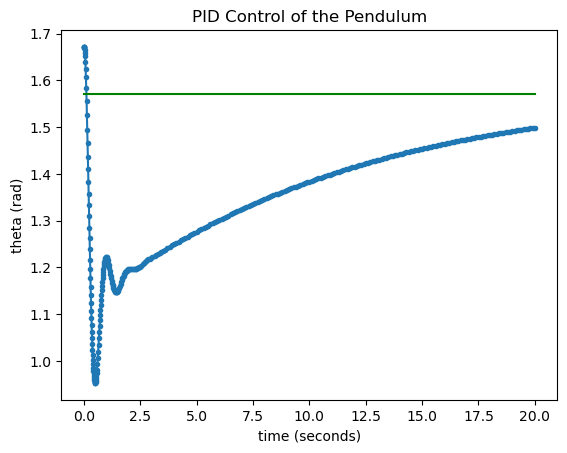

In [22]:
simulator = Simulator(diagram)
context = simulator.get_mutable_context()

desired_angle = np.pi/2

pendulum_context = diagram.GetMutableSubsystemContext(pendulum, context)
pendulum_context.get_mutable_continuous_state_vector().SetFromVector(
    [desired_angle + 0.1, 0.2]
)

diagram.get_input_port(0).FixValue(context, [desired_angle, 0.])


logger.FindMutableLog(context).Clear()

simulator.AdvanceTo(20)


log = logger.FindLog(simulator.get_context())
t = log.sample_times()
plt.figure()

plt.plot(t, log.data()[0,:], '.-')

plt.plot([t[0], t[-1]], [desired_angle, desired_angle], 'g')
plt.xlabel('time (seconds)')
plt.ylabel('theta (rad)')
plt.title('PID Control of the Pendulum');